<a href="https://colab.research.google.com/github/mik-nn/Cardio/blob/main/Parsing_Warfarin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install sweetviz
import sweetviz as sw
!pip install xlsxwriter

In [46]:
#@title Library
import os

import numpy as np
import pandas as pd
import re
import datetime as dt
from datetime import datetime, time
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.animation as animation
import seaborn as sns
from scipy.stats import pearsonr
#import phik
#from phik.report import plot_correlation_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

In [47]:
#@title Parameters
EXEL_HEADER = ['Number',
               'Institution',
               'Patient',
               'Gender',
               'Birthday',
               'Diagnosis',
               'Cardiovascular',
               'Drug',
               'Dose_src',
               'INR_Date',
               'INR',
               'PTI']
AGE_COUNT = 4
FEATURES = [
#            'Institution',
            'ID_Patient',
            'Sample',
            'Age',
            'Prev_Dose',
            'prev_INR',
            'date_diff',
            'Target_INR',
            'INR',
            'Dose']
FEATURES_DROP = []

In [48]:
#@title File Concatenate
#pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth',30)
PATH = '/content/drive/MyDrive/Warfarin/'
SRCPATH = PATH+'SRC/'
df = pd.DataFrame(columns=EXEL_HEADER)
for fname in os.listdir(SRCPATH):
#  print(f'Filename:{fname}')
  dff = pd.read_excel(SRCPATH+fname,header=None,skiprows=5,
                     names=EXEL_HEADER,parse_dates=False
                    ,index_col=None
                      )
  hindex = 9
#
  nochange = dff.Dose_src.str.contains('без изм.*',flags=re.IGNORECASE,regex=True,na=False)
  dff.Dose_src.loc[nochange] = np.NaN
  dff[EXEL_HEADER[:hindex]] = dff[EXEL_HEADER[:hindex]].fillna(method = 'ffill')
  dff.Institution[dff.Institution.isna()] = fname
#  print(f'Размер{df.shape}')
#  print(dff.head(5))
  df = df.append(dff,ignore_index=True)
  del dff
df = df[df['INR'].notna()]
df = df[df['INR_Date'].notna()]
df = df[df.Drug.str.contains('варфарин',flags=re.IGNORECASE, regex=True)]
print(df.shape)
#print(df.info())
#df.reset_index(inplace=True)
#df.set_index('index')
df.to_excel(PATH+'Warfarin_total_src.xlsx',index = False, engine = 'xlsxwriter')
print(df.head())

(2448, 12)
  Number Institution                        Patient   Gender  \
0    NaN    ЦАТ_КМРТ   Абдрахманов Гаряй Анварович   мужской   
1    NaN    ЦАТ_КМРТ   Абдрахманов Гаряй Анварович   мужской   
2    NaN    ЦАТ_КМРТ   Абдрахманов Гаряй Анварович   мужской   
3    NaN    ЦАТ_КМРТ  Абдрахманова Минигуль Габд...  женский   
4    NaN    ЦАТ_КМРТ  Абдульманов Ильсур Минигал...  мужской   

              Birthday                      Diagnosis Cardiovascular  \
0  1957-08-14 00:00:00  Протезирование аортального...            NaN   
1  1957-08-14 00:00:00  Протезирование аортального...            NaN   
2  1957-08-14 00:00:00  Протезирование аортального...            NaN   
3  1953-02-02 00:00:00  Протезирование митрального...            NaN   
4  1962-01-25 00:00:00  протезирование митрального...       ТИА 2022   

       Drug                   Dose_src             INR_Date   INR  PTI  
0  Варфарин                         3т  2022-09-16 00:00:00  3.41  NaN  
1  Варфарин  прибавить 1/

In [49]:
#@title Tokenize diases & Cardiovascular
diag = ''
for idx,row in df.iterrows():
  rd = re.sub('\s*[.,]\s*',',',str(row.Diagnosis))
  rd = re.sub('\s*\d{2}\.\d{4}\.*','',rd)

  rc = re.sub('\s*[.,]\s*',',',str(row.Cardiovascular))
  rc = re.sub('\s*\d{2}\.\d{4}\.*','',rc)
  diag += rd + ','+ rc +','
# Всего слов в тексте
diag.replace('\n',',')
diag.replace('нет','')
diag.replace(',,',',')
print(len(diag.split()))
tokens = Tokenizer(num_words=50,
#                   filters='!"#$%&()*+-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                   lower=True, split=',', oov_token='НС', char_level=False)
tokens.fit_on_texts(diag)
with open(PATH+'Diag.pickle', 'wb') as f:
    pkl.dump(tokens, f)
print(tokens.word_index)


8023
{'НС': 1, 'и': 2, ' ': 3, 'р': 4, 'а': 5, 'о': 6, 'е': 7, 'н': 8, 'т': 9, 'л': 10, 'п': 11, '2': 12, '0': 13, 'с': 14, 'к': 15, 'д': 16, 'я': 17, '1': 18, 'м': 19, 'б': 20, 'ф': 21, 'в': 22, 'й': 23, 'г': 24, 'ц': 25, 'ь': 26, 'з': 27, '8': 28, '3': 29, '9': 30, '5': 31, 'i': 32, 'ч': 33, '4': 34, 'ш': 35, 'ы': 36, '6': 37, 'n': 38, 'э': 39, 'у': 40, '7': 41, 'ж': 42, 'х': 43, 'a': 44, 'ю': 45, 'щ': 46, '\xa0': 47, 'q': 48, '№': 49, 'v': 50}


In [50]:
#@title Clean Data
# Create Patient_ID
df['Inst_ID'] = 10000
for index,value in enumerate(df.Institution.unique()):
  df.loc[df.Institution == value,'Inst_ID'] = (index+1)*10000
df['Patient_ID'] = 10000
for index,value in enumerate(df.Patient.unique()):
  df.loc[df.Patient == value,'Patient_ID'] = df[df.Patient == value].Inst_ID+index

#Clean Date
def clean_date( exel_date):
  if type(exel_date) == datetime:
    d_str = exel_date.strftime('%d.%m.%Y')
  elif type(exel_date) == str:
    rr = re.findall('\d+',exel_date)
    if len(rr) == 0: return ''
    if rr[0] == '31' and rr[1] == '11': rr[0] = '30'      # Correct date
    if len(rr[1]) == 1: rr[1] = '0'+rr[1]
    elif len(rr[1]) == 6:
      rr.append(rr[1][2:6])
      rr[1] = rr[1][0:2]
    if len(rr[2]) == 2: rr[2] = '20'+rr[2]
    d_str = rr[0]+'.'+rr[1]+'.'+rr[2]
  else:
    d_str = np.nan
    print(f'date mismatch: {exel_date}')
  return datetime.strptime(d_str,'%d.%m.%Y')

for idx,row in df.iterrows():
  df.loc[idx,'INR_Date'] = clean_date(row.INR_Date)
df['INR_Date'] = pd.to_datetime(df.INR_Date)

# Clean Age
# Create period between INR_Date and Birthday
def clean_age(age_str,analyse_date):
  if type(analyse_date)  == str:
    print(analyse_date)
#    analyse_date = daytime.strftime(analyse_date)
  if type(age_str) == datetime:
    b_date = age_str
  elif re.search('\d{2}(\.|,)\d{2}\.(\d{2}|\d{4})',age_str):
    r = list(map(int,re.findall('\d{4}|\d{2}',age_str)))
#    print(age_str,r)
    b_date = datetime(r[2],r[1],r[0])
  else:
#    print(age_str)
    r = re.search('\d{2}',age_str)
    age = int(r.group()*365.25)
    b_date = b_date - age
    print(type(b_date),type(age))
  age = analyse_date - b_date
#  print(age.days)
  return int(age.days)
df = df[df['INR_Date'].notna()]
df['AgeDays'] = np.nan
for i,row in df.iterrows():
  df.loc[i,'AgeDays'] = clean_age(row.Birthday,row.INR_Date)
df['Age'] = round(df.AgeDays/365.25)
#Пребразуем даты в формат 'dd.mm.YYYY'
df['INR_Date'] = pd.to_datetime(df.INR_Date, errors='coerce').dt.date

#Пол
df.Gender.replace(r'^[мМ].*','1' ,regex=True,inplace=True)
df.Gender.replace(r'^[жЖ].*','0' ,regex=True,inplace=True)

In [51]:
#INR
#df.INR = df.INR.str.replace('\s+','')
#if False: '''
df = df.reset_index(drop=True)
for idx,row in df.iterrows():
#  print( f'{idx}: {row.INR}=>',end='')
  r = re.sub('2,69    ., 2,34','2.34',str(row.INR))
  r = re.sub('\s+','',r)
  r = re.sub('(\.+,*)|(\.*,+)','.',r)
  df.INR.iloc[idx] = float(r)
#  print(r)
#'''

In [52]:
#Dose parsing
SKIP_THRESHOLD =3
df = df.sort_values(by=['Patient_ID','INR_Date'])
#df.Dose_src.str.replace('^\s+$','без изменений') # Search empty Dose
df = df.reset_index(drop=True)
df['Dose'] = ''
df['Skip_D'] = 0
prev_dose = ''
for i,row in df.iterrows():
  if row.Dose_src == ' ':
    print(idx,':missing dose')
  if re.search('%d\.*$',str(row.Dose_src)):
    row.Dos_src = re.sub('$','мг')
  if (re.search('[Бб]ез изм',str(row.Dose_src))) and (df.Patient_ID.iloc[i-1] == row.Patient_ID):
    rr = str(df.Dose_src.iloc[i-1])
    if row.Dose_src == rr:
      r = prev_dose
  else:
    r = str(row.Dose_src)
    if (re.search('[Пп]роп',r)):
      if row.INR >SKIP_THRESHOLD:
        if (re.search('2 дня',r)):
          df.Skip_D.iloc[i] = 2
        else: df.Skip_D.iloc[i] = 1
      r = re.sub('\D+','',r)

# Alternating doses
    r = r.replace('1т 3 дня, 1,25 т 1 день', '4.25/4') #(1*3+1.25)/4
    r = r.replace('1+3/4таб. - среда, суббота, ост дни- по 2  таб. вечером.', '13.5/7') #((1+3/4)*2+2*5)/7
    r = r.replace('2,5мг по 1,5 таблетки 5 дней, затем 3/4 2 дней','9/7') #(1.5*5+2*3/4)/7
    r = r.replace('','')
    r = r.replace('1+1/4т и 1 таб. чередовать ч\з день','2,25/2') #(1+1/4+1)/2
    r = r.replace('1+3/4 таб.1+1/2 через день вечером','3.25/2') #((1+3/4)+(1+1/2))/2
    myre = re.compile('(приб|умень|добав|убав)(.*)(\d[.,/]\d+)\D*\.*$')
    r = myre.sub(r'\3',r)
    myre = re.compile('(приб|умень|добав|убав|велич)(.*)(\d+)\D*$')
    r = myre.sub(r'\3',r)
    r = re.sub(' 1 раз в день$','',r)
    r = re.sub('^2,5мг по','',r)
    r = re.sub('контроль через.*\w+','',r)
#    r = re.sub(r'(\d\.\d+\s*)-(\s*\d\.\d+).*',r'\(\1+\2\)\/2',r)
    r = re.sub('\s*,','.',r)  #' ,'=>'.'
    r = re.sub(r'\\','/',r)
    r = re.sub(r'[Ттn]\w*\.*','т',r)
    r = re.sub(r'\s*т','т',r)
    r = re.sub('1т 1','1+1',r)
  prev_dose = r
# To number
  r = re.sub('^-','',r)
  r = re.sub('т\+','+',r)
  r = re.sub(r'2.5\s*мг\s(по)*\s*','',r)
  r = re.sub('^\D','',r) #remove non numeric character at the begin
  r = re.sub('т','',r)  # remove т
  r = re.sub('\D+$','',r) # skip nondigital character at end
  r = re.sub('2.5-4','4',r)
  r = re.sub('2[.,]5-2[.,]75','2.625',r)
  r = re.sub('1[.,]25\s*-\s*1[.,]5','1.375',r)
  if re.search('-',r):
    print('Некорректное значение дозы\n',row.Dose_src)
    r = input('Введите новое значение')
# convert from tablets to mg
  if re.search('мг',r): r =re.sub('мг[\.,]*','',r)
  else: r = '('+r+')*2.5'
  try:
    df.Dose[i] = float(eval(r))
  except:
    print('Evaluation error: ', end ='')
    print(f'{i}:{row.Dose_src} => {r} (МНО={row.INR})')
    df.Dose[i] = np.nan
# Clean bad Dose values
df = df[df.Dose.notna()]

Некорректное значение дозы
 1,-1,7таб
Введите новое значение
Введите новое значение
Evaluation error: 452:1,-1,7таб => ()*2.5 (МНО=2.02)
Некорректное значение дозы
 1,-1,7таб
Evaluation error: 453:1,-1,7таб => ()*2.5 (МНО=2.1)
Некорректное значение дозы
 2.5мг 1,5-1.75 
Введите новое значение
Введите новое значение
Evaluation error: 460:2.5мг 1,5-1.75  => ()*2.5 (МНО=1.5)
Некорректное значение дозы
 2.5мг 1,5-1.75 
Evaluation error: 461:2.5мг 1,5-1.75  => ()*2.5 (МНО=1.8)
Evaluation error: 1393:        => ()*2.5 (МНО=2.55)
Evaluation error: 1832:nan => ()*2.5 (МНО=3.0)
Evaluation error: 1833:nan => ()*2.5 (МНО=4.46)
Evaluation error: 1834:nan => ()*2.5 (МНО=3.18)


In [53]:
#Add difference data
sample =1
df['Sample'] = 1
df['Prev_Dose'] = np.nan
df['prev_INR'] = np.nan
df['date_diff'] = np.nan
df['Prev_SkipD'] = 0
for i in range(1,len(df)):
  if df.Patient_ID.iloc[i] == df.Patient_ID.iloc[i-1]:
    sample +=1
    df['Prev_Dose'].iloc[i] = df.Dose.iloc[i-1]
    df['prev_INR'].iloc[i] = df.INR.iloc[i-1]
    df['Prev_SkipD'].iloc[i] = df.Skip_D.iloc[i-1]
    df['date_diff'].iloc[i] = (df.INR_Date.iloc[i]-df.INR_Date.iloc[i-1]).days
  else:
    sample = 1
  df['Sample'].iloc[i] = sample


In [54]:
#Унифицируем диагнозы по словарю
import json
abbreviations = None
with open('/content/drive/MyDrive/Warfarin/diag.json', 'r') as f:
    abbreviations = json.load(f)
def unify_diagnose_by_dict(diagnose, dictionary=abbreviations):
    text = ''
    for key in dictionary.keys():
        for word in dictionary[key]:
          if word in diagnose:
            text += key
    return text

for idx,row in df.iterrows():
    rd = re.sub('\s*[.,]\s*',',',str(row.Diagnosis))
    rd = re.sub('\s*\d{2}\.\d{4}\.*','',rd)
    rd = unify_diagnose_by_dict(rd,abbreviations)
    row.Diagnosis = rd
    rc = re.sub('\s*[.,]\s*',',',str(row.Cardiovascular))
    rc = re.sub('\s*\d{2}\.\d{4}\.*','',rc)
    rc = unify_diagnose_by_dict(rc,abbreviations)
    row.Cardiovascular = rc


In [55]:
# Add Target INR
df['Cardiovascular'] = df['Cardiovascular'].astype(str)
# -добавляем целевой МНО из инструкции исхдя из диагноза
df['Target_INR'] = 2.5
df.Target_INR[(df.Diagnosis.str.contains('протез',flags=re.IGNORECASE, regex=True) &
              df.Diagnosis.str.contains('аорт', flags=re.IGNORECASE, regex=True)
              |df.Cardiovascular.str.contains('протез',flags=re.IGNORECASE, regex=True) &
              df.Cardiovascular.str.contains('аорт', flags=re.IGNORECASE, regex=True))&
              (df.Diagnosis.str.contains('ФП', flags=re.IGNORECASE, regex=True)
              |df.Diagnosis.str.contains(' фибрил', flags=re.IGNORECASE, regex=True))
              |df.Diagnosis.str.contains('митр', flags=re.IGNORECASE, regex=True)] =3

df.Target_INR[(df.Diagnosis.str.contains('протез',flags=re.IGNORECASE, regex=True) &
              df.Diagnosis.str.contains('митр', flags=re.IGNORECASE, regex=True)
              |df.Cardiovascular.str.contains('протез',flags=re.IGNORECASE, regex=True) &
              df.Cardiovascular.str.contains('митр', flags=re.IGNORECASE, regex=True))&
              (df.Diagnosis.str.contains('ФП', flags=re.IGNORECASE, regex=True)
              |df.Diagnosis.str.contains(' фибрил', flags=re.IGNORECASE, regex=True))] =3.5


In [56]:
#Cleal Age < 10 > 95
df = df.loc[(df.Age >10) & (df.Age < 95)]
#Clean INR > 10
# Инструкция предполагает, что в этом случае человека нужно помещать в стационар
# и вводить витамин K  внутривенно
#
#Find Patient_Id with High_INR

High_INR = df.Patient_ID[df.INR > 10]
df = df[~df['Patient_ID'].isin(High_INR)]
df.Dose = df.Dose.astype(float)

# Clean incorrect dose
High_Dose = df.Patient_ID[df.Dose > 12.5]
df = df[~df['Patient_ID'].isin(High_Dose)]

df = df.reset_index(drop=True)
print(df.shape)
print(df.info())

(2263, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Number          2201 non-null   object 
 1   Institution     2263 non-null   object 
 2   Patient         2263 non-null   object 
 3   Gender          2263 non-null   object 
 4   Birthday        2263 non-null   object 
 5   Diagnosis       2263 non-null   object 
 6   Cardiovascular  2263 non-null   object 
 7   Drug            2263 non-null   object 
 8   Dose_src        2263 non-null   object 
 9   INR_Date        2263 non-null   object 
 10  INR             2263 non-null   object 
 11  PTI             1571 non-null   object 
 12  Inst_ID         2263 non-null   int64  
 13  Patient_ID      2263 non-null   int64  
 14  AgeDays         2263 non-null   float64
 15  Age             2263 non-null   float64
 16  Dose            2263 non-null   float64
 17  Skip_D          2263 n

In [57]:
print(df.columns)
df = df[['Inst_ID','Institution',
        'Patient_ID','Patient',
        'Sample', 'Gender', 'Birthday',
        'Age','AgeDays',
        'Diagnosis','Cardiovascular',
        'Target_INR',
        'Dose_src','Skip_D','Dose',
        'INR', 'INR_Date', 'date_diff','PTI',
        'Prev_SkipD','Prev_Dose','prev_INR']]

Index(['Number', 'Institution', 'Patient', 'Gender', 'Birthday', 'Diagnosis',
       'Cardiovascular', 'Drug', 'Dose_src', 'INR_Date', 'INR', 'PTI',
       'Inst_ID', 'Patient_ID', 'AgeDays', 'Age', 'Dose', 'Skip_D', 'Sample',
       'Prev_Dose', 'prev_INR', 'date_diff', 'Prev_SkipD', 'Target_INR'],
      dtype='object')


In [58]:
#df.set_index('index')
with pd.ExcelWriter(PATH+'Warfarin_total_src.xlsx', engine='xlsxwriter') as writer:
  df.to_excel(writer, sheet_name='Sheet1',index=False)
 # ws = writer.sheets['Sheet1']
  for column in df:
    column_width = min(50,max(df[column].astype(str).map(len).max(), len(column)))
    col_idx = df.columns.get_loc(column)
    writer.sheets['Sheet1'].set_column(col_idx, col_idx, column_width)
#  for column in df:
#    ws.column_dimensions[column].bestFit = True
  writer.save()

                                             |          | [  0%]   00:00 -> (? left)


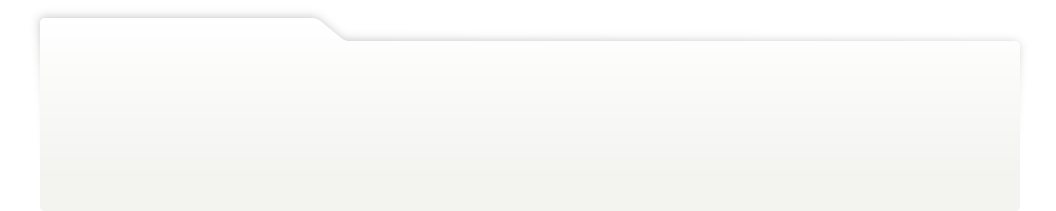
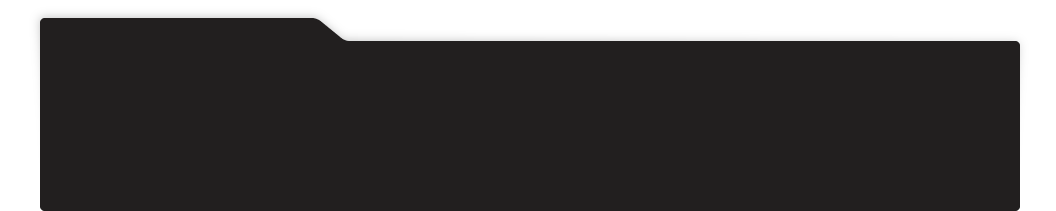
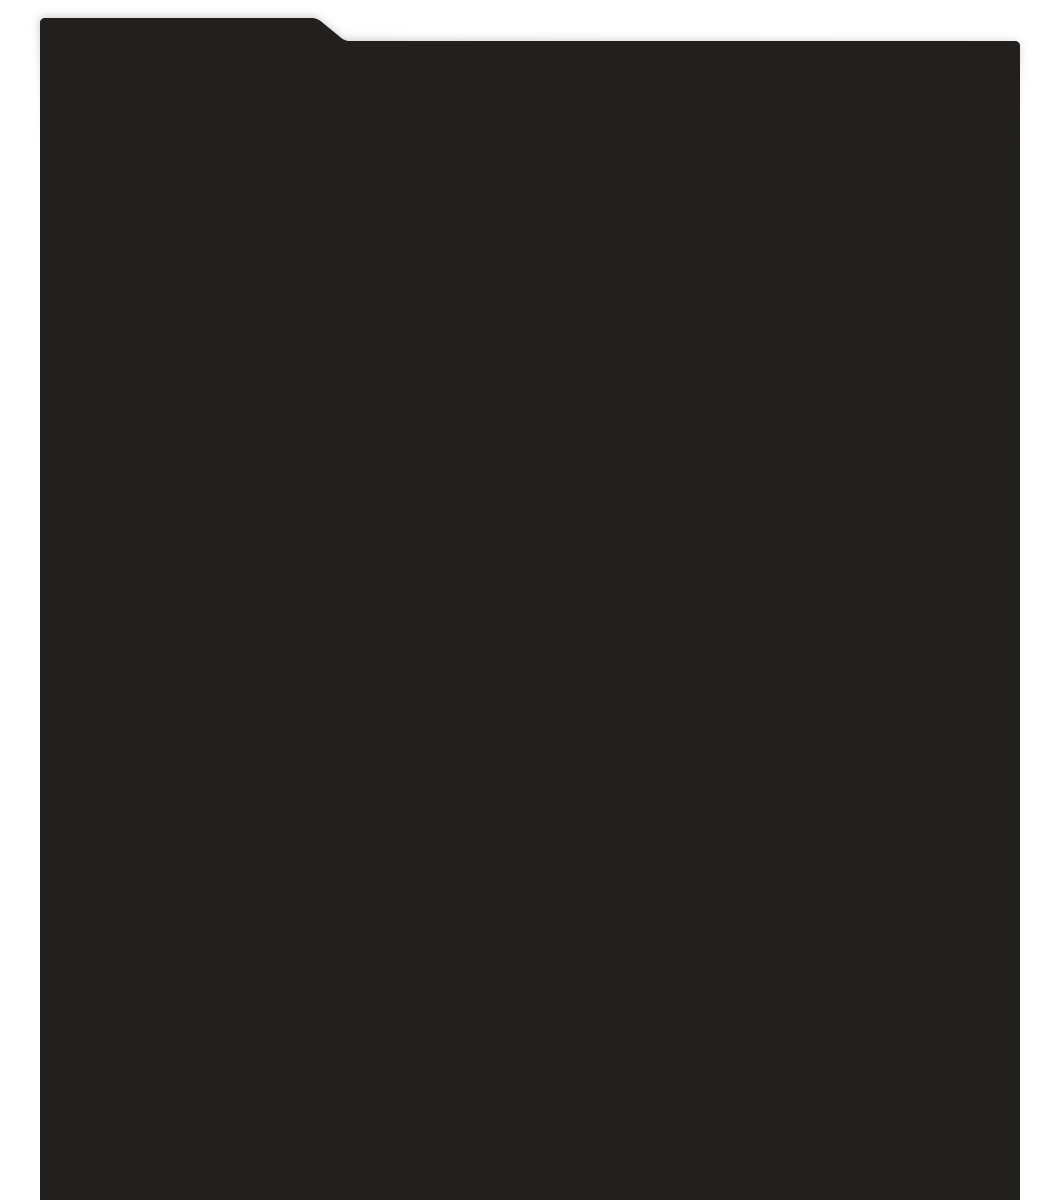
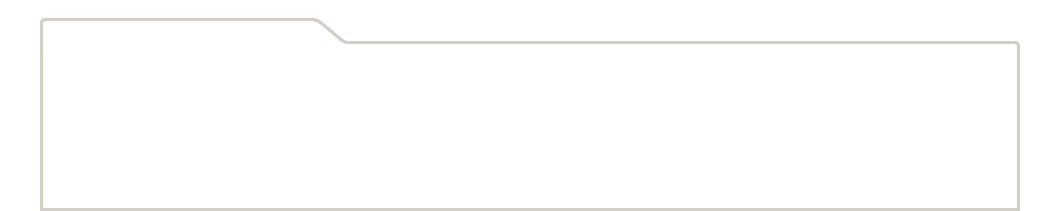
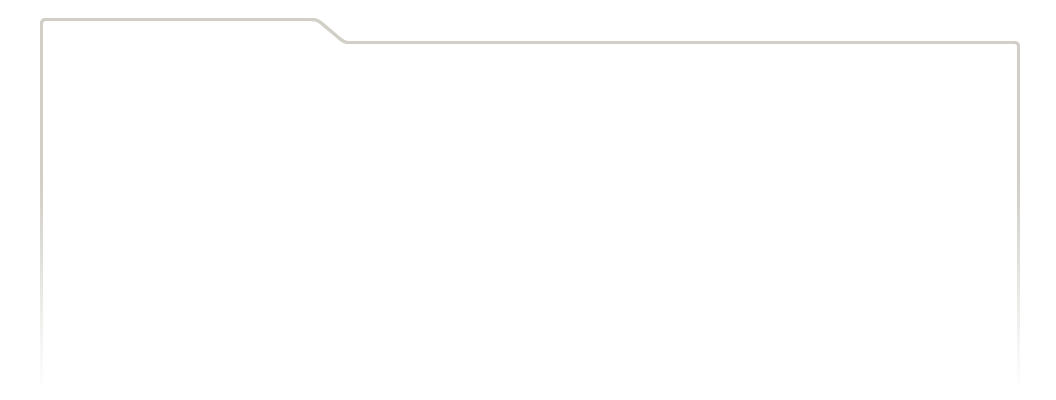
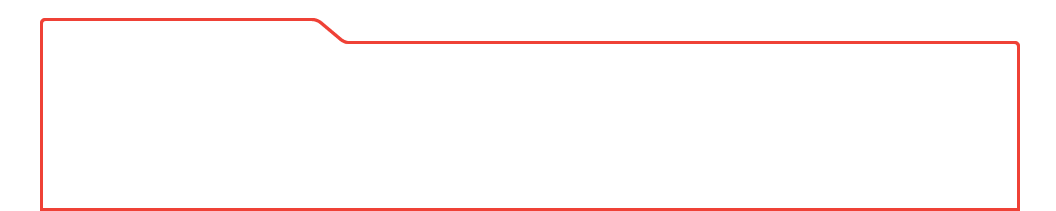
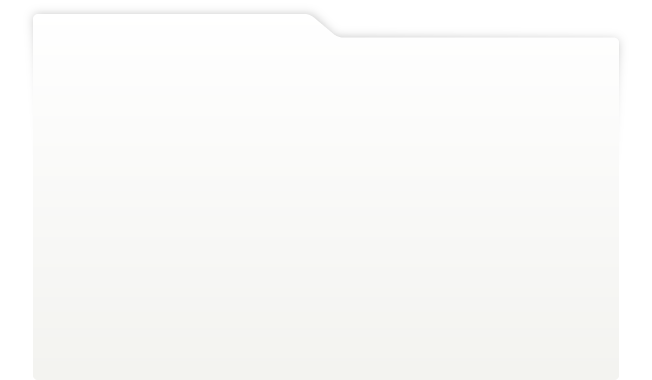
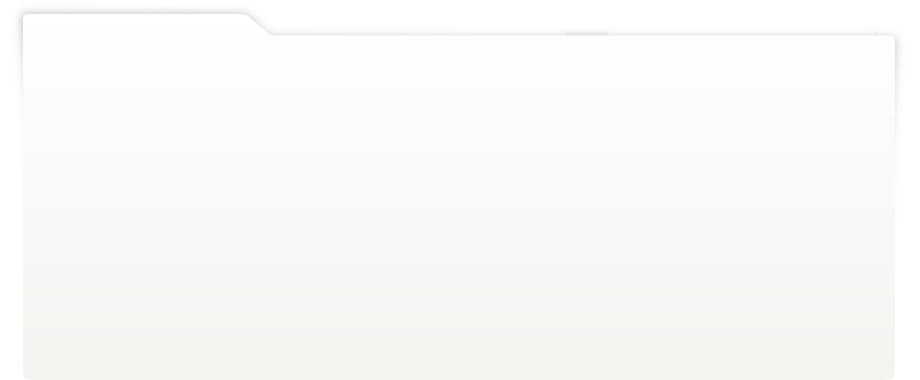
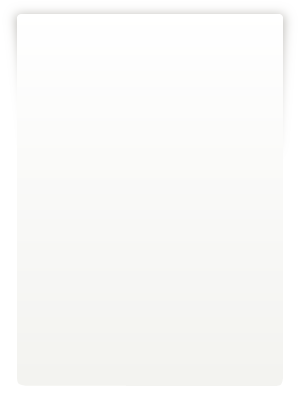
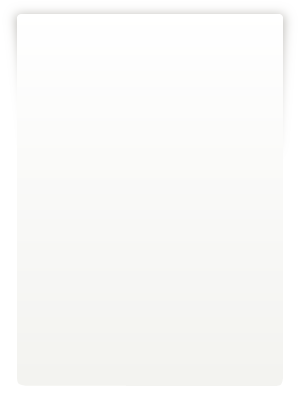
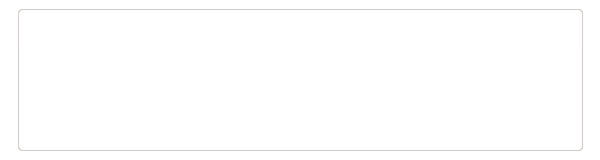
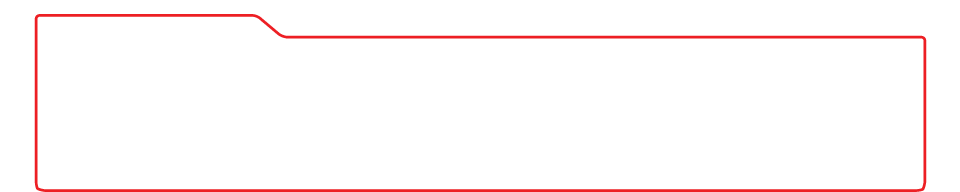
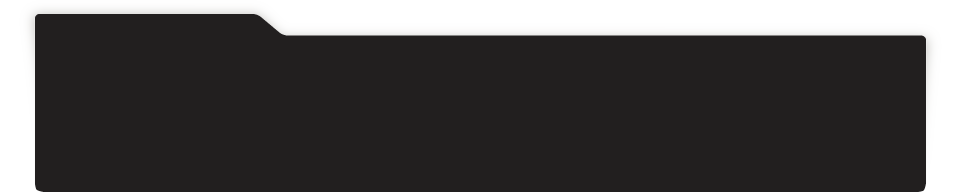
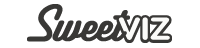
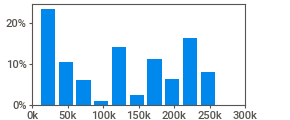
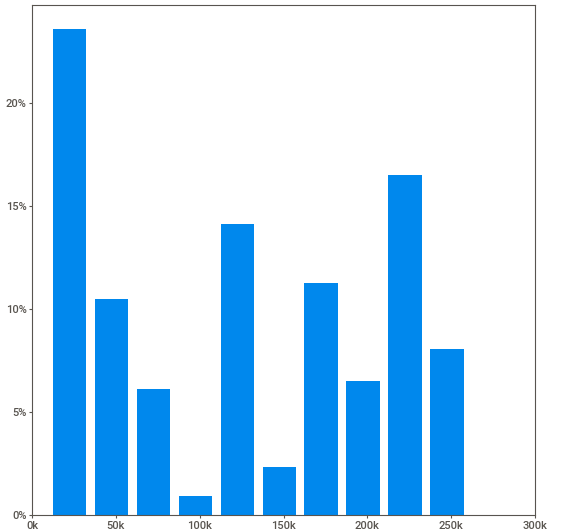
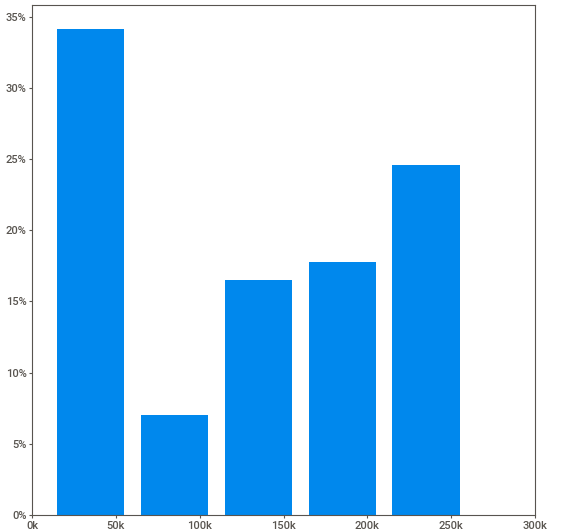
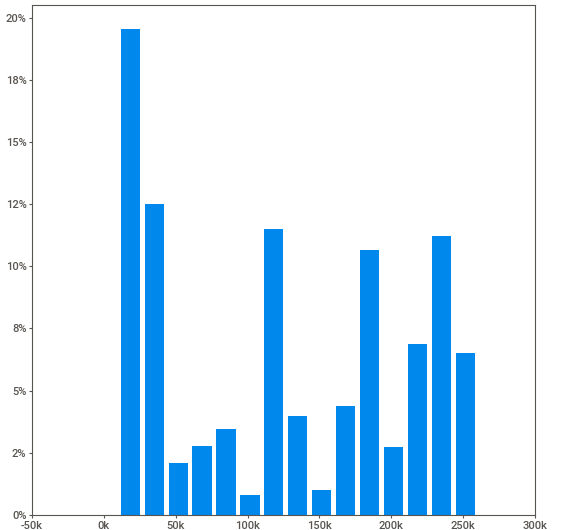
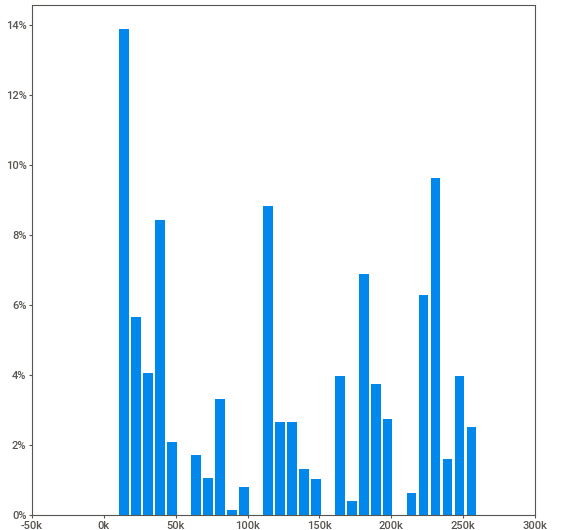
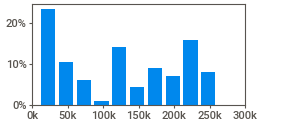
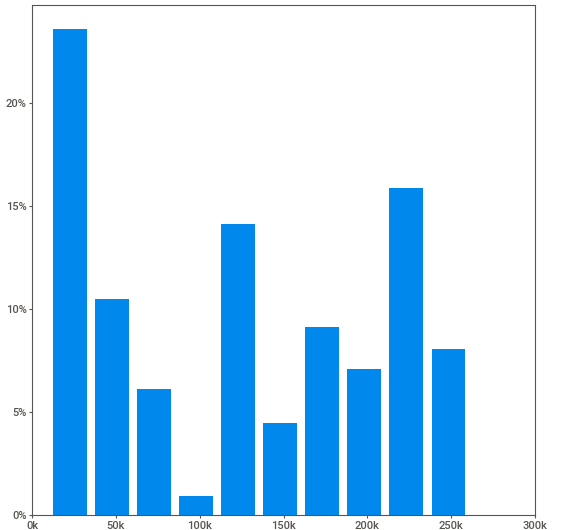
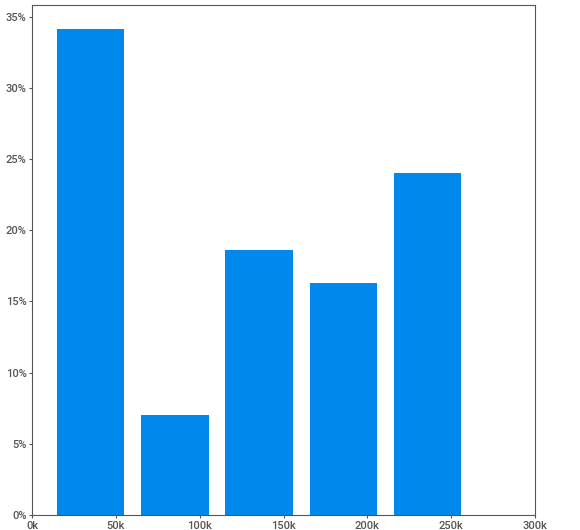
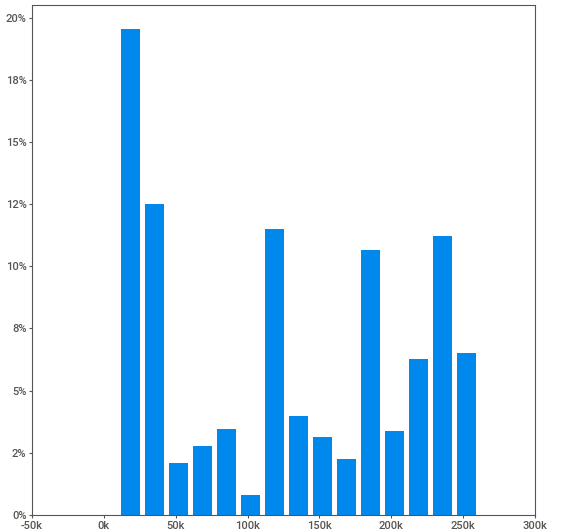
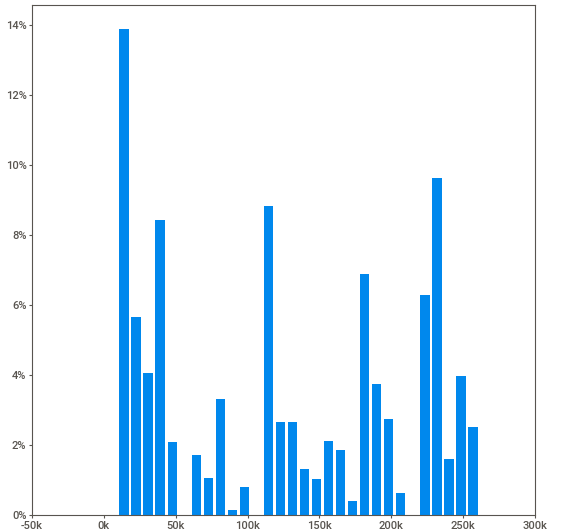
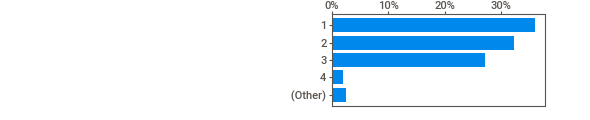
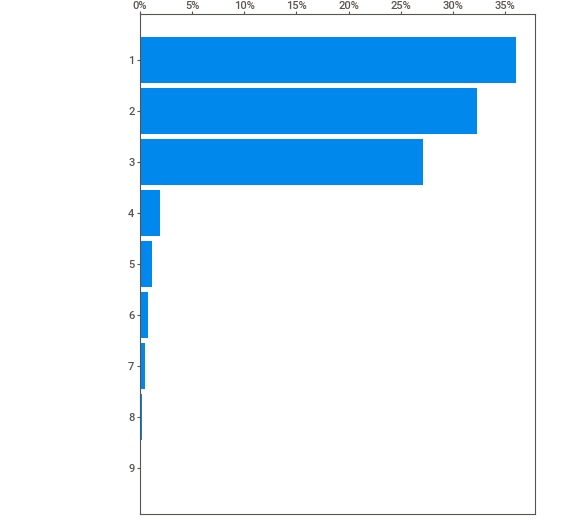
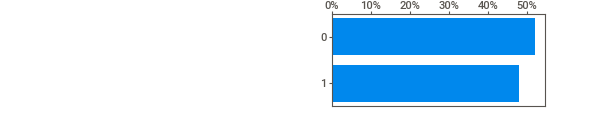
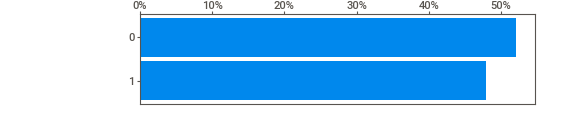
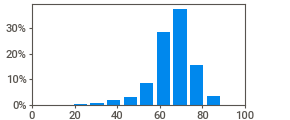
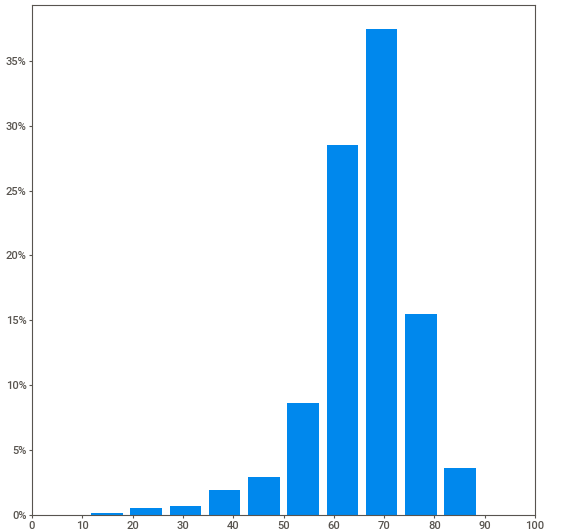
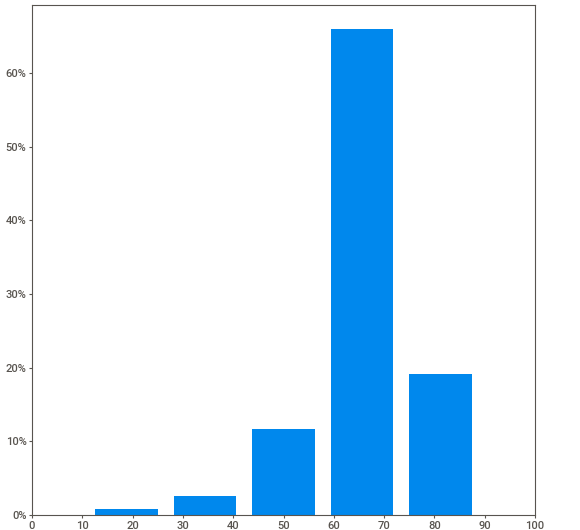
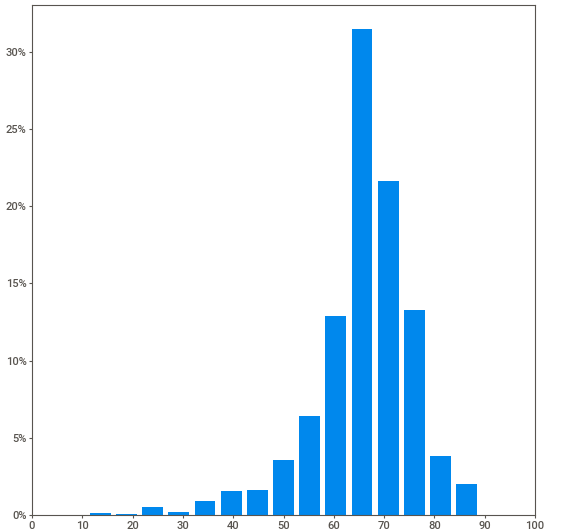
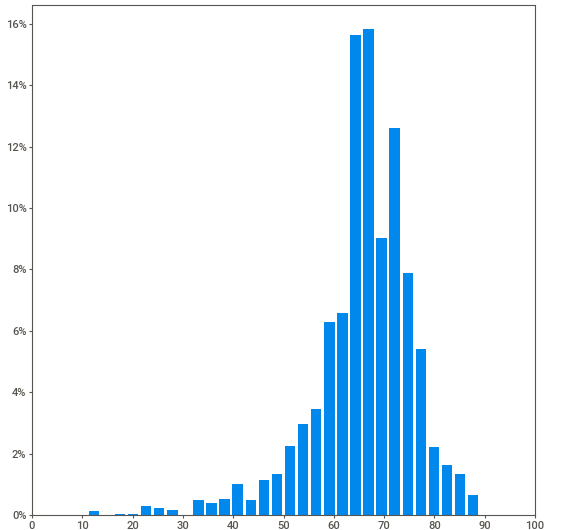
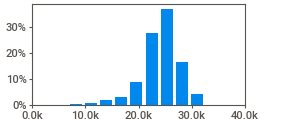
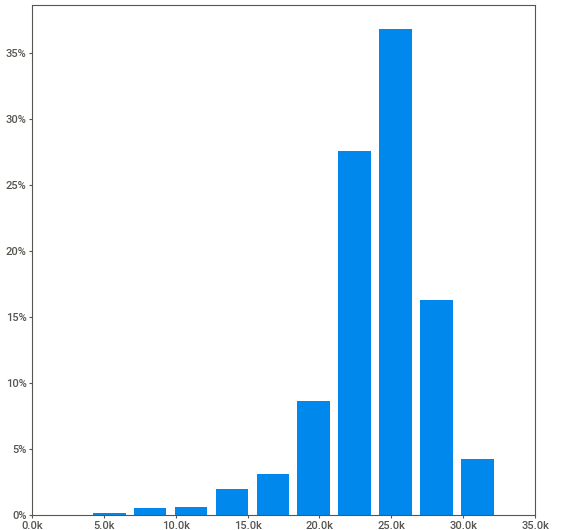
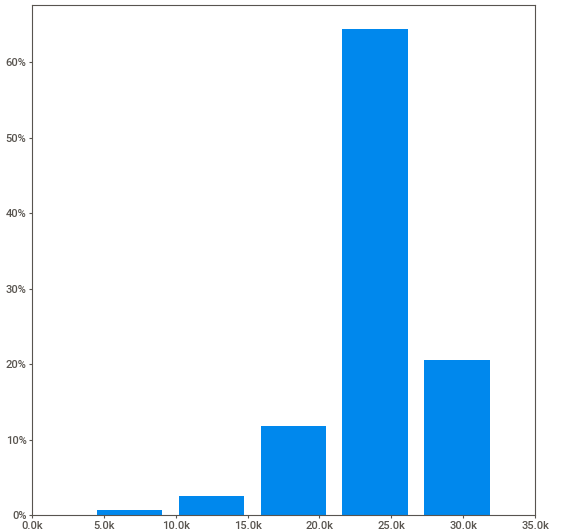
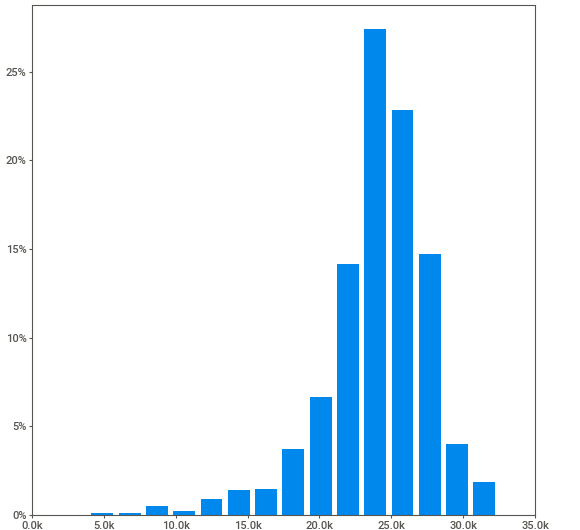
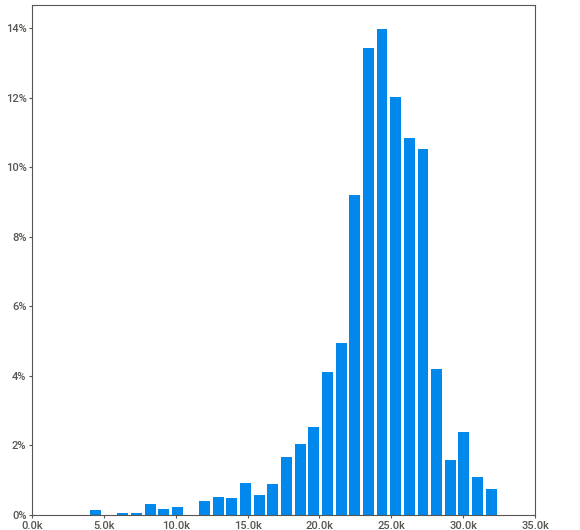
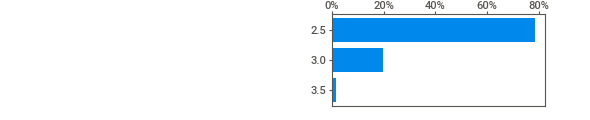
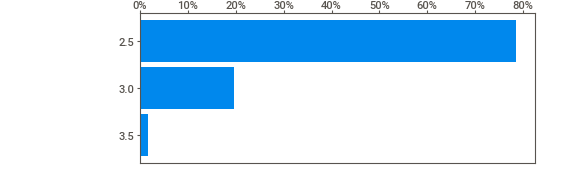
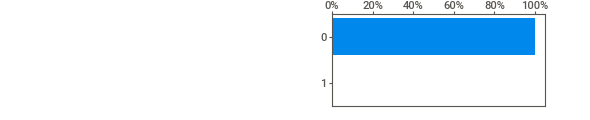
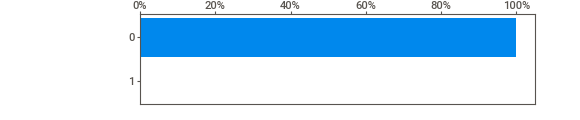
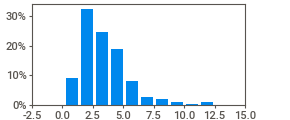
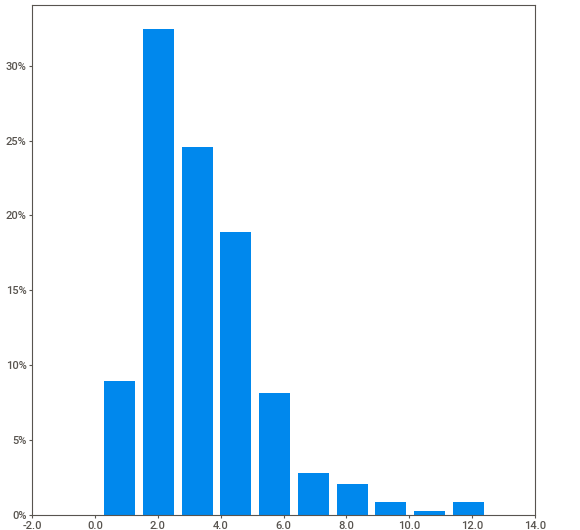
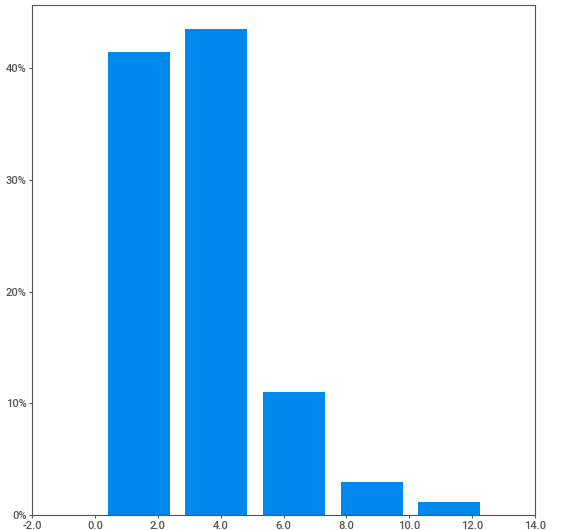
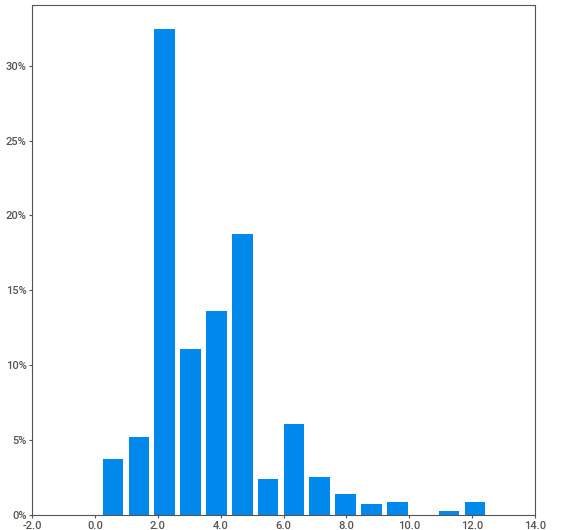
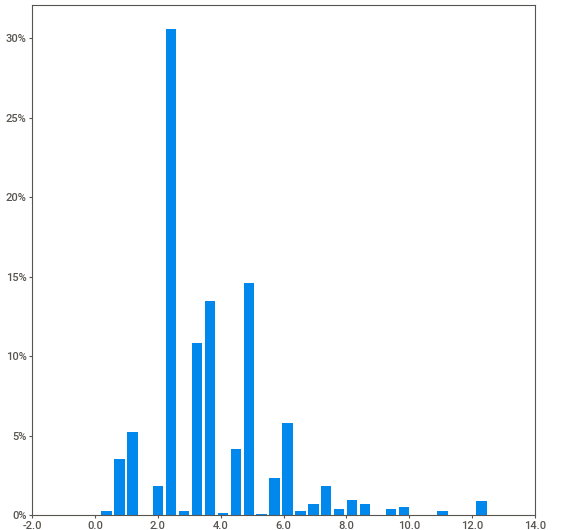
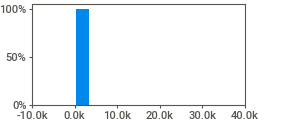
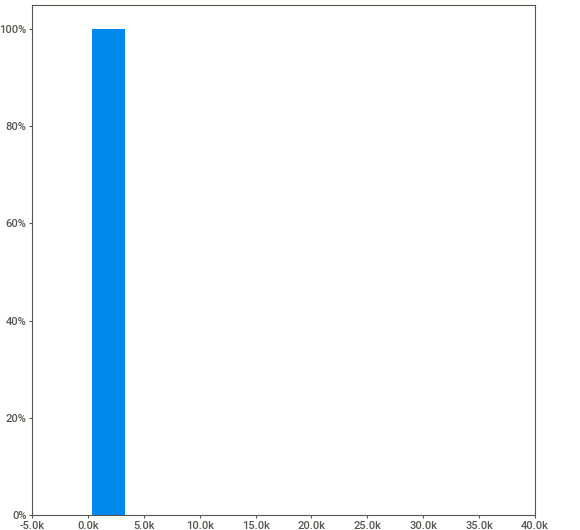
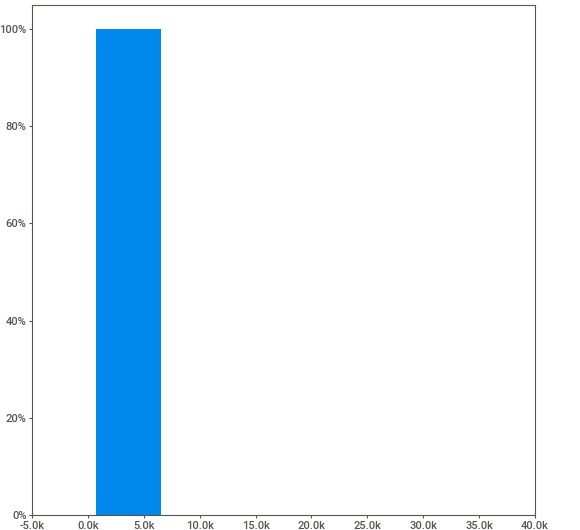
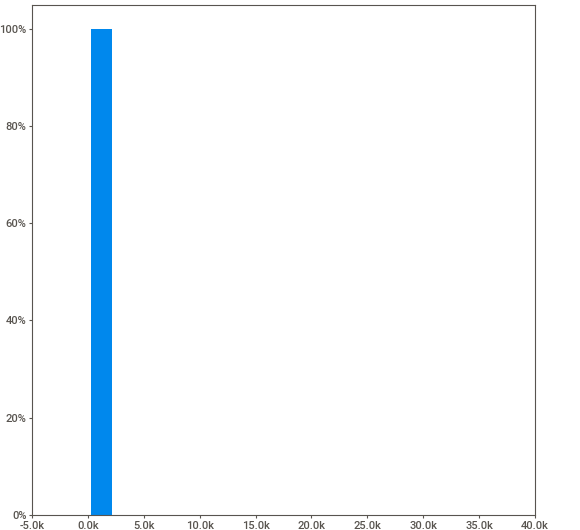
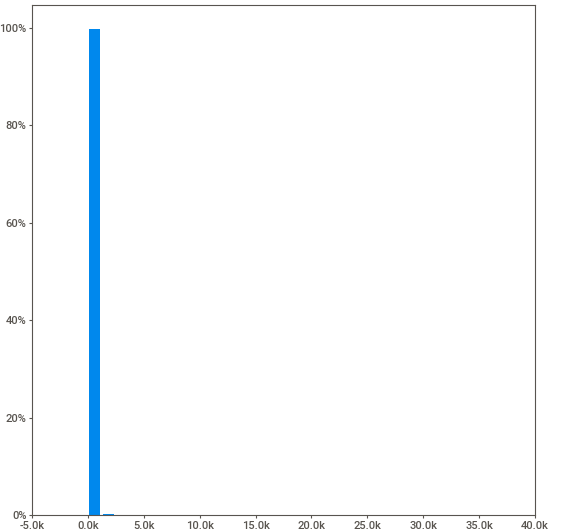
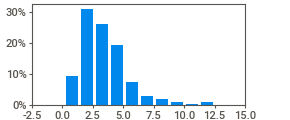
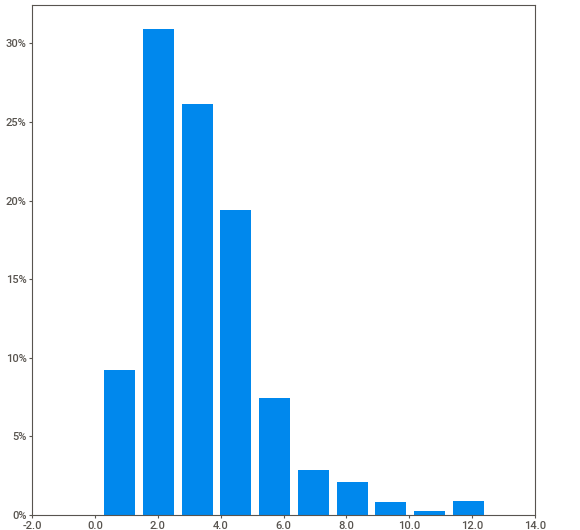
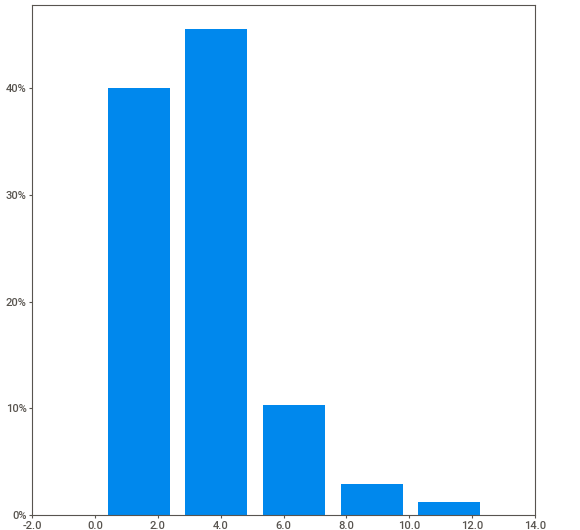
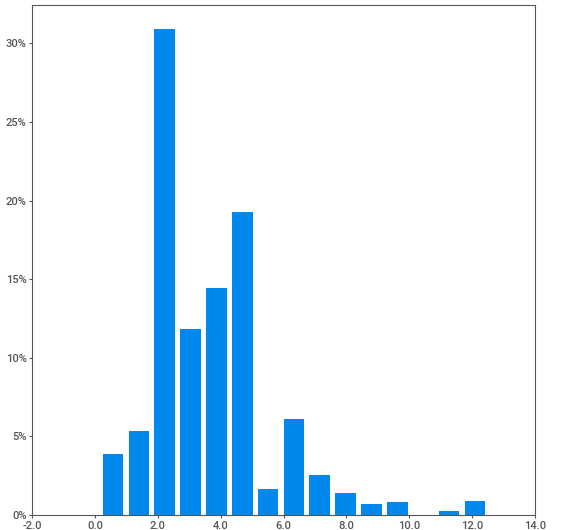
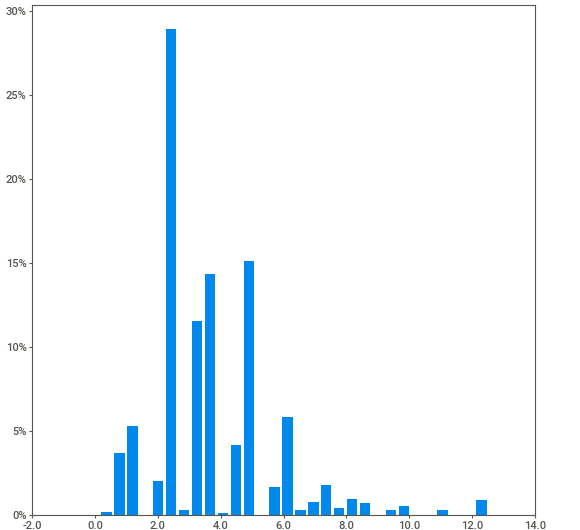
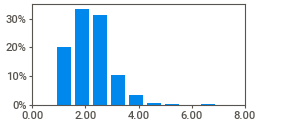
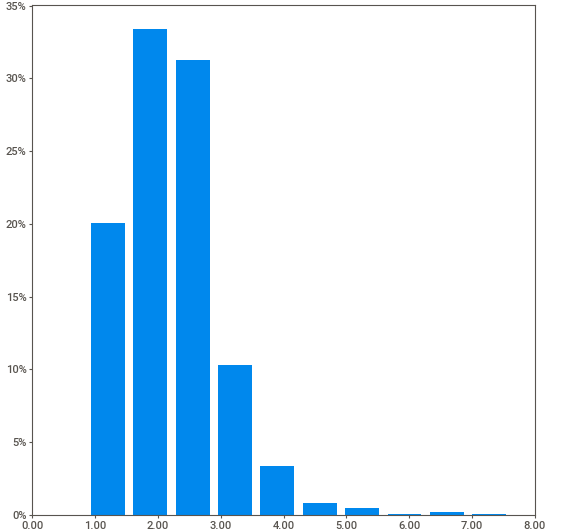
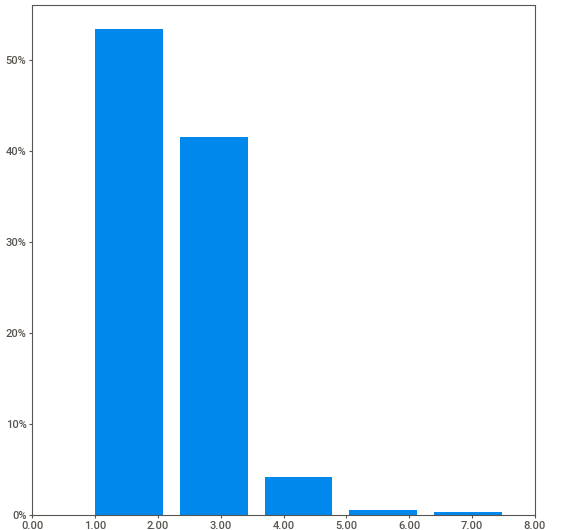
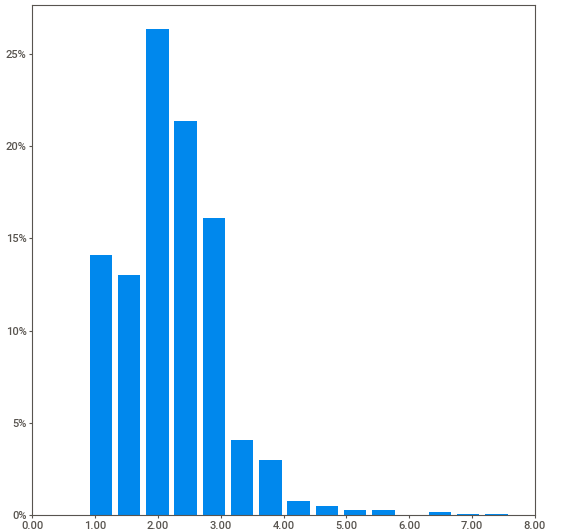
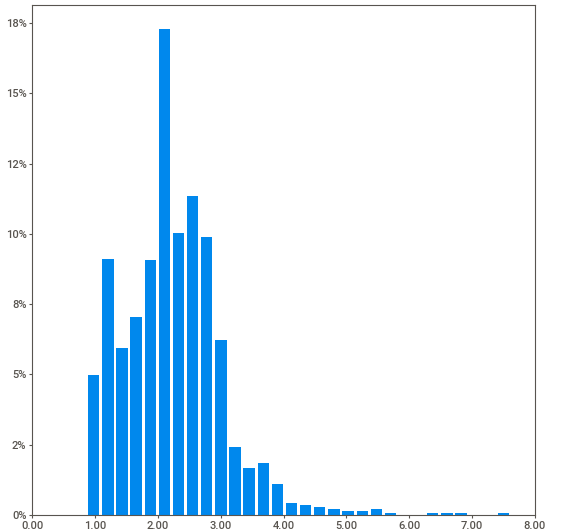
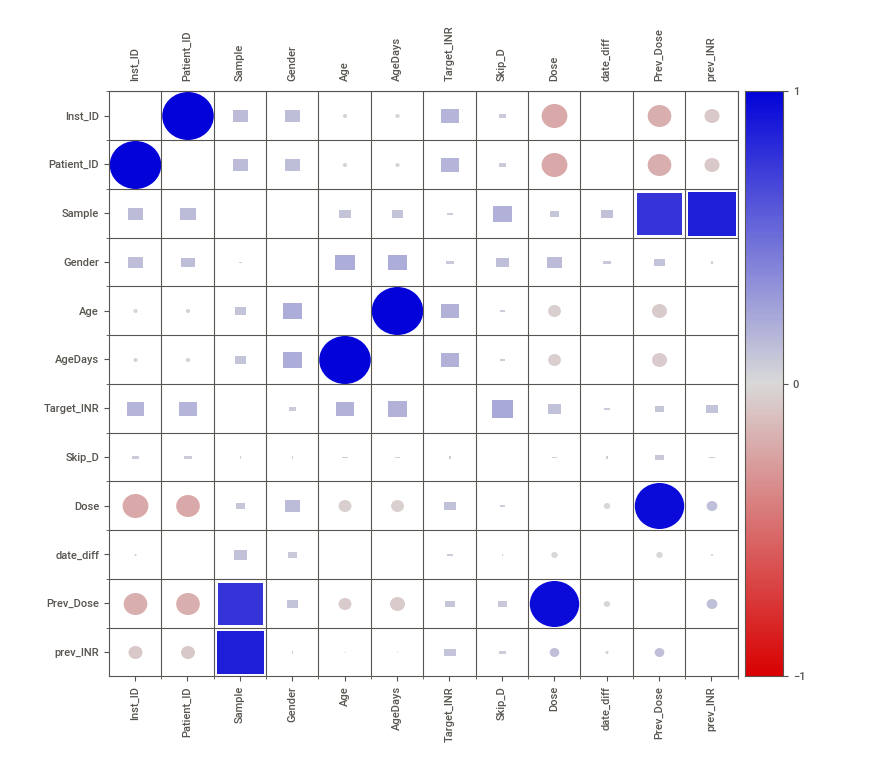
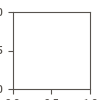

In [59]:
ar = sw.analyze(
      df[['Inst_ID',
        'Patient_ID',
        'Sample', 'Gender',
        'Age','AgeDays',
        'Target_INR',
        'Skip_D','Dose',
        'INR', 'INR_Date', 'date_diff',
        'Prev_Dose','prev_INR']]
        )
ar.show_notebook()